## Example 2.1 replicated from paper 
#### Online EM algorithm for mixture with application to internet traffic modeling Z. Liua,∗, J. Almhanaa, V. Choulakiana, R. McGormanb
https://pdfs.semanticscholar.org/b87b/e267aa2976898a647316f5ef3dbfc635b5b2.pdf

In [1]:
from math import exp, log


def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)


def poisson(x, l):
    return pow(l, x) * exp(-l) / factorial(x)

In [2]:
import numpy as np
s = np.random.poisson(5, 10000)


def generate_data(g, l, size):
    data = np.array([])
    sizes = [int(gi * size) for gi in g]
 
    for gi, li in zip(sizes, l):
        data = np.append(data, np.random.poisson(li, gi))
    return data

data = generate_data([0.4, 0.6], [1, 5], 10000) 

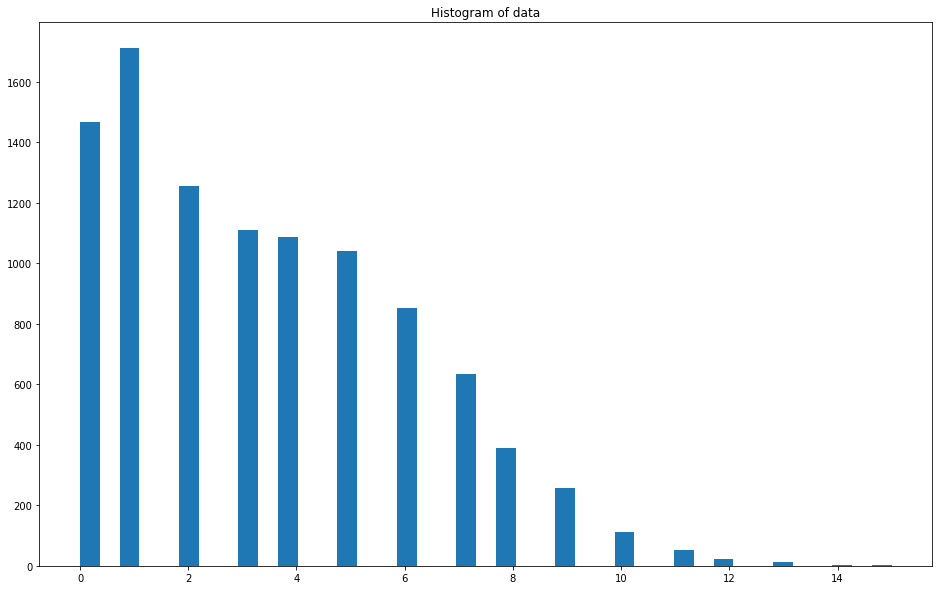

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

plt.hist(data, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of data")
plt.show()

In [4]:
class EMAlgorithm:
    def __init__(self, gammas, lambdas):
        # gammas and lambdas are the initialization
        self.gammas = np.array(gammas)
        self.lambdas = np.array(lambdas)
        assert len(gammas) == len(lambdas)

        self.m = len(gammas)

        # list of the gammas_i
        # each element represent the value of gamma_i for an iteration
        self.gammas_over_time = [[] for _ in gammas]
        self.lambdas_over_time = [[] for _ in lambdas]
        self.likelihood = []

    def calculate_participation(self, data):
        """
        :param data: n array of the data to train
        :return: an (n, m) array of the participation of each data point to each poisson distribution
                m is the number of distributions
        """
        f = np.zeros(shape=(len(data), self.m))
        for i, x in enumerate(data):
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            f[i] = (self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas])) / total_x

        return f
    
    def calculate_likelihood(self, data):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in data:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def run(self, data, iterations=100):
        n = len(data)
        
        for _ in range(iterations):
            f = self.calculate_participation(data)

            # update gammas and lambdas
            temp_sum = f.sum(axis=0)
            self.gammas = temp_sum / n

            temp = np.zeros(self.m)
            for i, x in enumerate(data):
                temp = temp + x * f[i]
            self.lambdas = temp / temp_sum

            # append last value of gammas and lambdas
            for i, gamma_i in enumerate(self.gammas):
                self.gammas_over_time[i].append(gamma_i)

            for i, lambda_i in enumerate(self.lambdas):
                self.lambdas_over_time[i].append(lambda_i)

            self.likelihood.append(self.calculate_likelihood(data))

    def get_gammas(self):
        return self.gammas_over_time

    def get_lambdas(self):
        return self.lambdas_over_time

    def get_likelihood(self):
        return self.likelihood

In [5]:
em = EMAlgorithm([0.5, 0.5], [0.6, 4])
em.run(data, iterations=100)

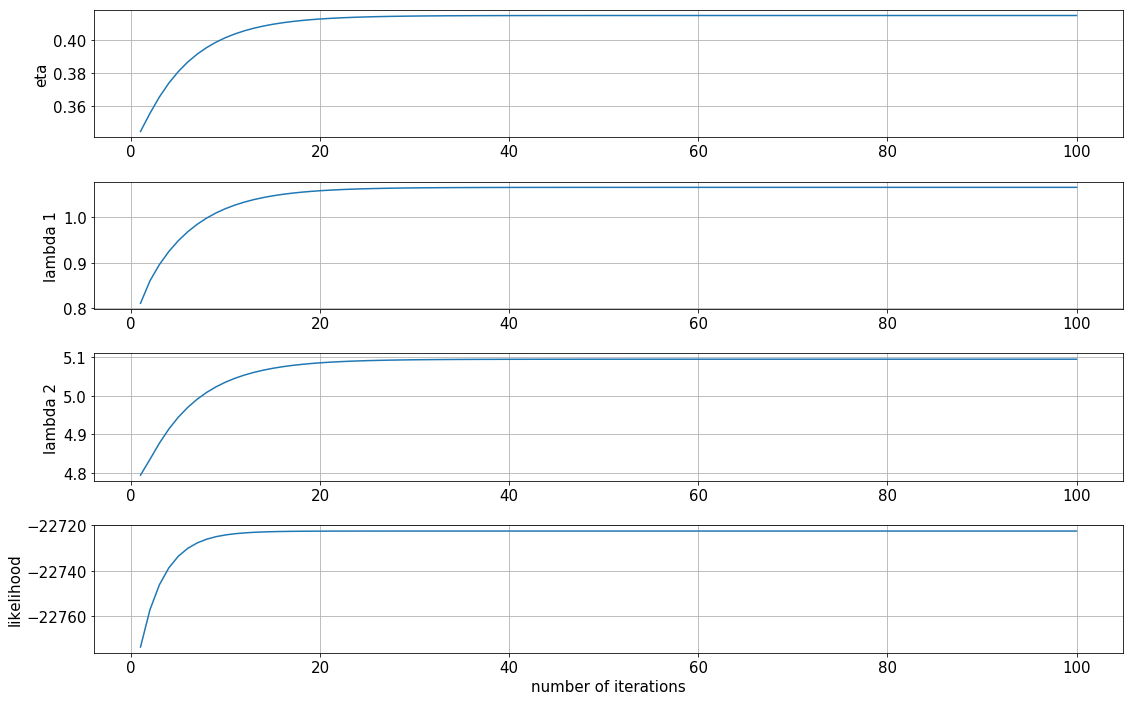

In [6]:
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

matplotlib.rcParams.update({'font.size': 15})

x = range(1, len(em.get_gammas()[1]) + 1)

plt.title('EM results')

plt.subplot(4, 1, 1)
plt.plot(x, em.get_gammas()[0])
plt.ylabel('eta')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(x, em.get_lambdas()[0])
plt.ylabel('lambda 1')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(x, em.get_lambdas()[1])
plt.ylabel('lambda 2')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(x, em.get_likelihood())
plt.ylabel('likelihood')
plt.xlabel('number of iterations')
plt.grid()

plt.tight_layout()
plt.show()

Some small differences in relation with the results in the paper regarding the likelihood

### Online EM

In [7]:
# Algorithm2.1 from the paper


class EMBatchSize:
    def __init__(self, gammas, lambdas, batch_size):
        self.em = EMAlgorithm(gammas, lambdas)
        self.batch_size = batch_size

    def train_batch(self, data):
        """
        :param data: the batch data 
        updates gammas, lambdas and likelihood
        """
        self.em.run(data, iterations=1)

    def get_new_batch(self, data, pos):
        n = len(data)

        assert self.batch_size <= n

        if self.batch_size + pos <= n:
            return data[pos: pos + self.batch_size], pos + self.batch_size
        
        return np.concatenate((data[pos: n], data[0: self.batch_size - (n - pos)]), axis=0), self.batch_size - (n - pos)

    def train(self, data, batch_number=100):
        """
        :param data: the whole dataset to train from 
        :param batch_number: the number of iterations to perform on data with barch_size self.batch_size
        """

        # the starting position of the current batch in the data
        pos = 0
        for _ in range(batch_number):
            batch, pos = self.get_new_batch(data, pos)

            self.train_batch(batch)

    def get_gammas(self):
        return self.em.gammas_over_time

    def get_lambdas(self):
        return self.em.lambdas_over_time

    def get_likelihood(self):
        return self.em.likelihood

Data is created by the mixture of two poissons

As a batch calculation is going to take place random shuffle data so that data from all mixtures are throughout the dataset

In [8]:
np.random.shuffle(data)

In [9]:
online_em_naive = EMBatchSize([0.5, 0.5], [0.6, 4], 500)
online_em_naive.train(data, 100)

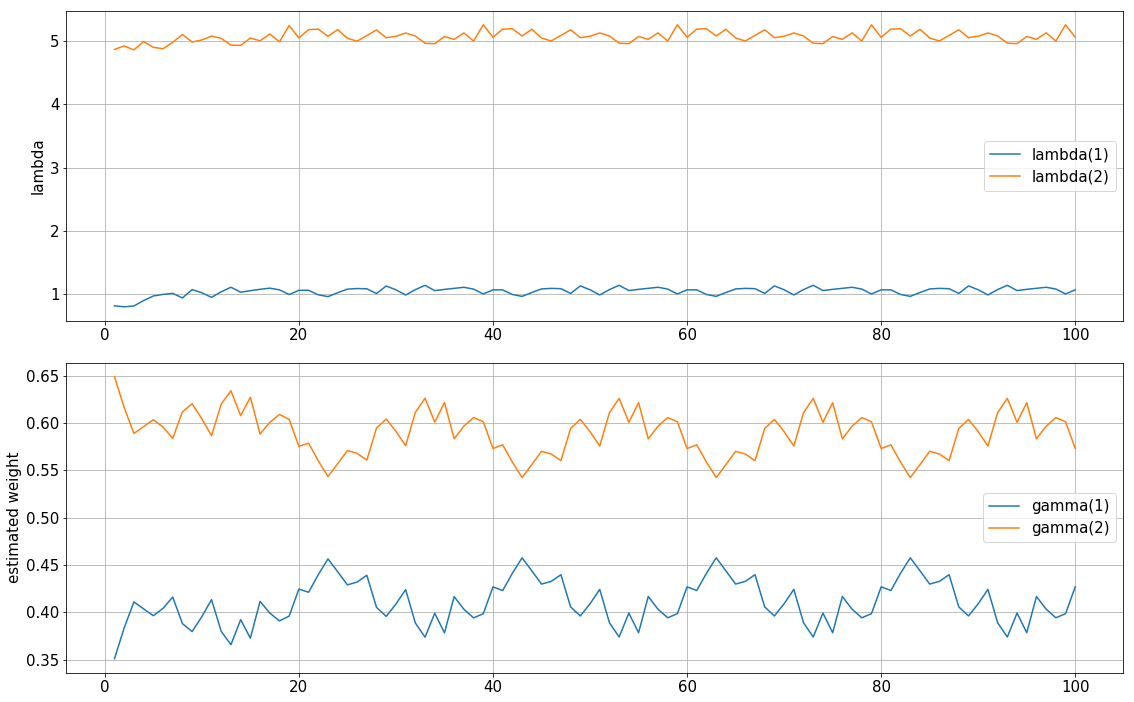

In [10]:
def plot_results(em_algorithm):
    import matplotlib
    from pylab import rcParams
    rcParams['figure.figsize'] = 16, 10
    rcParams['legend.loc'] = 'best'

    matplotlib.rcParams.update({'font.size': 15})

    x = range(1, len(em_algorithm.get_gammas()[1]) + 1)

    plt.title('Online EM 2.1 results')

    plt.subplot(2, 1, 1)
    plt.plot(x, em_algorithm.get_lambdas()[0])
    plt.plot(x, em_algorithm.get_lambdas()[1])
    plt.ylabel('lambda')
    plt.legend(['lambda(1)','lambda(2)'])
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(x, em_algorithm.get_gammas()[0])
    plt.plot(x, em_algorithm.get_gammas()[1])
    plt.ylabel('estimated weight')
    plt.legend(['gamma(1)','gamma(2)'])
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_results(online_em_naive)

Another test. Same as algorthm 2.1 with the exception that the batch_size is calculated by the formula <hr>

$$s_{k} = 1 + 2 + ... + k$$

In [34]:
class EMIncrementBatchSize:
    def __init__(self, gammas, lambdas, batch_size):
        self.em = EMAlgorithm(gammas, lambdas)
        self.batch_size = batch_size

    def train_batch(self, data):
        """
        :param data: the batch data 
        updates gammas, lambdas and likelihood
        """
        self.em.run(data, iterations=1)

    def get_new_batch(self, data, pos):
        n = len(data)

        assert self.batch_size <= n

        if self.batch_size + pos <= n:
            return data[pos: pos + self.batch_size], pos + self.batch_size
        
        return np.concatenate((data[pos: n], data[0: self.batch_size - (n - pos)]), axis=0), self.batch_size - (n - pos)

    def train(self, data, batch_number=100):
        """
        :param data: the whole dataset to train from 
        :param batch_number: the number of iterations to perform on data with barch_size self.batch_size
        """

        # the starting position of the current batch in the data
        pos = 0
        for _ in range(batch_number):
            batch, pos = self.get_new_batch(data, pos)
            
            self.batch_size += 1

            self.train_batch(batch)

    def get_gammas(self):
        return self.em.gammas_over_time

    def get_lambdas(self):
        return self.em.lambdas_over_time

    def get_likelihood(self):
        """
        returns a normalized log likelihood divided by the number of elements in each iteration 
        """
        next_batch_size = self.batch_size
        return np.array(self.em.likelihood) / np.array(list(range(next_batch_size - len(self.em.likelihood),next_batch_size)))

In [35]:
data[:10]

array([ 5.,  1.,  0.,  2.,  0.,  2.,  7.,  7.,  6.,  8.])

An initial value of batch_size is used

This is to make sure different values will be used in the first iteration to avoid getting stucked

In [36]:
online_em_increment_batch_size = EMIncrementBatchSize([0.5, 0.5], [0.6, 4], 10)
online_em_increment_batch_size.train(data, 200)

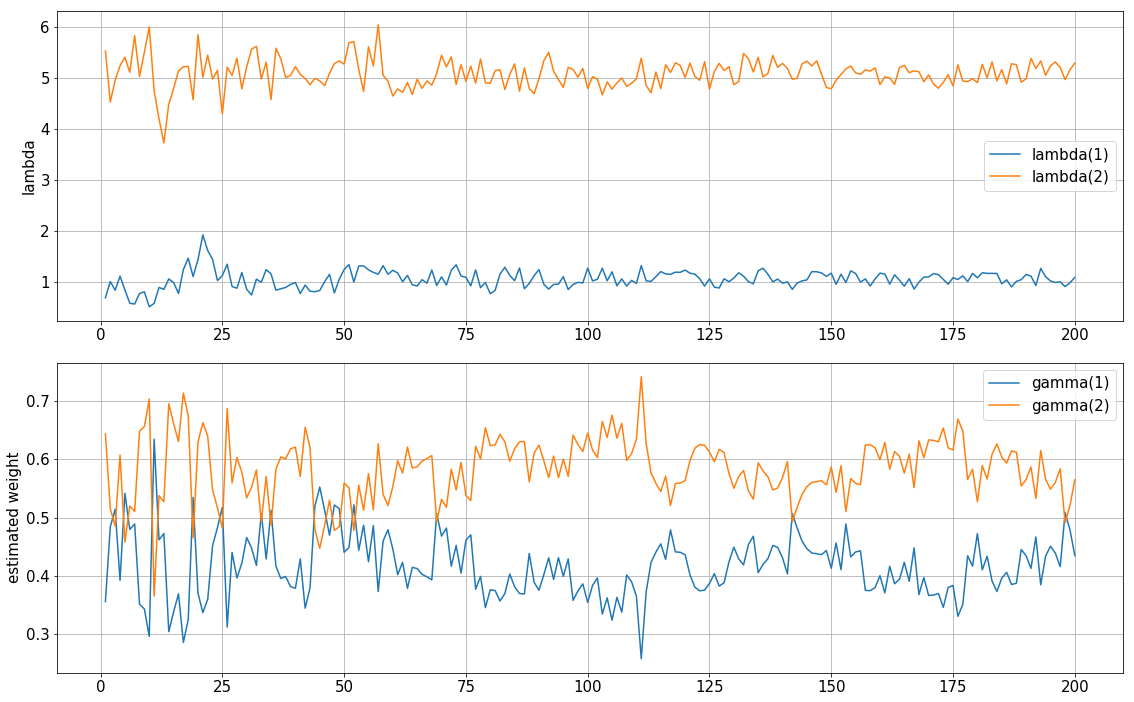

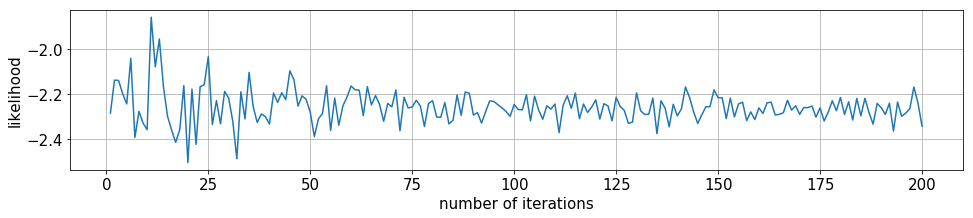

In [37]:
plot_results(online_em_increment_batch_size)

x = range(1, len(online_em_increment_batch_size.get_likelihood()) + 1)

plt.subplot(3, 1, 1)
plt.plot(x, online_em_increment_batch_size.get_likelihood())
plt.ylabel('likelihood')
plt.xlabel('number of iterations')
plt.grid()

The above results are not as smooth as in the paper

FIX THIS

Even in the last iteration only around 200 samples are used, a realtively small number that cannot represent the whole truth
This phenomenon can be mitigated with a larger step size for each iteration

The final result, marked as Algorithm 2.2

In [139]:
class OnlineEM:
    def __init__(self, gammas, lambdas, segment_length):
        # gammas and lambdas are the initialization
        self.gammas = np.array(gammas)
        self.lambdas = np.array(lambdas)
        self.segment_length = segment_length

        assert len(gammas) == len(lambdas)

        # number of poisson mixtures
        self.m = len(gammas)

        # list of the gammas_i
        # each element represent the value of gamma_i for an iteration
        self.gammas_over_time = [[] for _ in gammas]
        self.lambdas_over_time = [[] for _ in lambdas]
        self.likelihood = []

        # number of current iteration
        self.iteration_k = 0

    def calculate_participation(self, data):
        """
        :param data: n array of the data to train
        :return: an (n, m) array of the participation of each data point to each poisson distribution
                m is the number of distributions
        """
        f = np.zeros(shape=(len(data), self.m))
        for i, x in enumerate(data):
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            f[i] = (self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas])) / total_x

        return f

    def calculate_likelihood(self, data):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in data:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def train_batch(self, data):
        """
        :param data: the batch data 
        updates gammas, lambdas and likelihood
        """

        self.iteration_k += 1
        n = len(data)

        f = self.calculate_participation(data)

        # update gammas and lambdas
        temp_sum = f.sum(axis=0)

        update_factor = 1 / (pow(self.iteration_k, 0.6))
        self.gammas = (1 - update_factor) * self.gammas + update_factor * (temp_sum / n)

        temp = np.zeros(self.m)
        for i, x in enumerate(data):
            temp = temp + x * f[i]
        self.lambdas = (1 - update_factor) * self.lambdas + update_factor * (temp / temp_sum)

        # append last value of gammas and lambdas
        for i, gamma_i in enumerate(self.gammas):
            self.gammas_over_time[i].append(gamma_i)

        for i, lambda_i in enumerate(self.lambdas):
            self.lambdas_over_time[i].append(lambda_i)

        self.likelihood.append(self.calculate_likelihood(data))

    def get_new_batch(self, data, pos):
        n = len(data)

        assert self.segment_length <= n

        if self.segment_length + pos <= n:
            return data[pos: pos + self.segment_length], pos + self.segment_length

        return np.concatenate((data[pos: n], data[0: self.segment_length - (n - pos)]), axis=0), self.segment_length - (n - pos)

    def train(self, data, batch_number=100):
        """
        :param data: the whole dataset to train from 
        :param batch_number: the number of iterations to perform on data with barch_size self.batch_size
        """

        # the starting position of the current batch in the data
        pos = 0
        for _ in range(batch_number):
            batch, pos = self.get_new_batch(data, pos)

            self.train_batch(batch)

    def get_gammas(self):
        return self.gammas_over_time

    def get_lambdas(self):
        return self.lambdas_over_time

    def get_likelihood(self):
        return self.likelihood

In [140]:
online_em = OnlineEM([0.5, 0.5], [0.6, 4], 500)
online_em.train(data, 100)

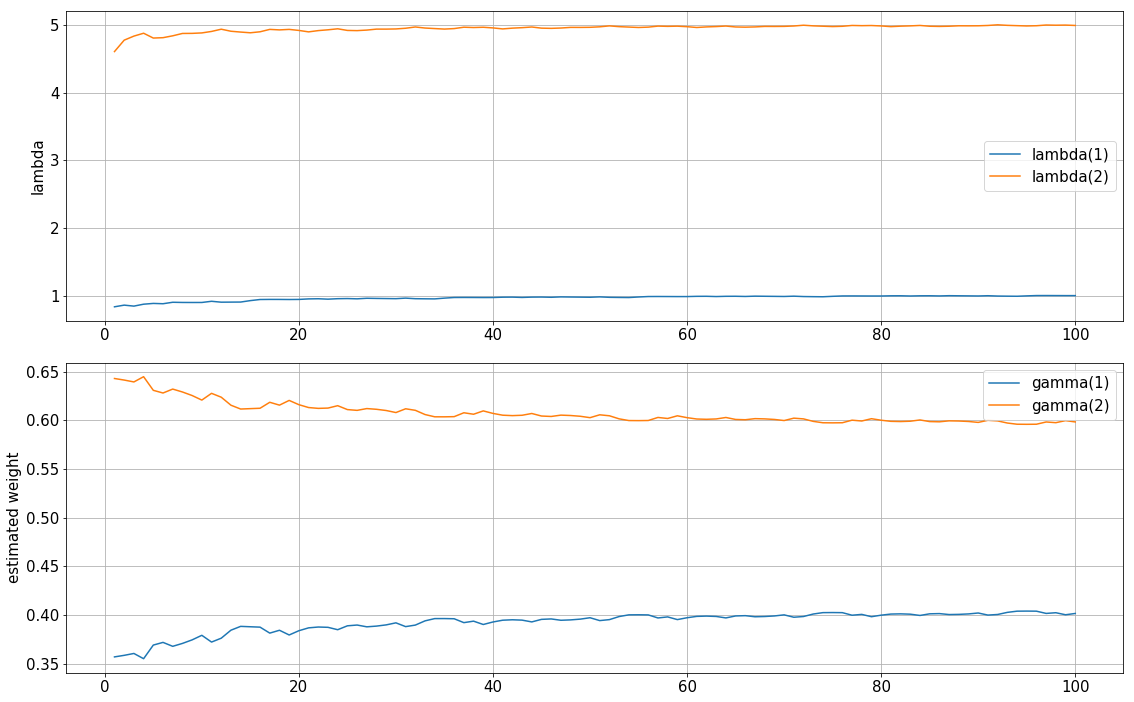

In [141]:
plot_results(online_em)